# Topic Modelling Using Trump's Tweets

Here we will be looking to model the topics president Trump has tweeted about. Using the dynamic topic modelling algorithm provided by the gensim library, we will observe the evolution of these topics during the span of a year, between May 1st, 2019 and May 1st, 2020.

## Import Libraries

In [ ]:
import pandas as pd
from collections import defaultdict
from gensim import corpora
#import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import nltk
import re
from nltk.corpus import stopwords

#sns.set(style='ticks', palette='Set2')
#sns.despine()

In [ ]:
%tb
from setuptools import setup

def readme():
    with open('README.rst') as f:
        return f.read()

setup(name='dtmvisual',
      version='1.0.0',
      description='This package consists of functionalities for dynamic topic modelling and its visualization',
      url='https://github.com/GSukr/dtmvisual',
      author='Svitlana',
      author_email='svitlana.galeshchuk@gmail.com',
      license='MIT',
      packages=['dtmvisual'],
      install_requires=['gensim==3.4.0', 'pickle-mixin', 'pprint', 'seaborn==0.8.1', 'matplotlib==2.0.2'],
      include_package_data=True,
      zip_safe=True)

In [ ]:
pip install --upgrade gensim

     |████████████████████████████████| 24.2MB 164kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Import the data 
We will be importing the tweet data from my google drive, using only the tweets from May 1st, 2019 to May 1st, 2020. Any rewteets are removed, since we are mostly intrested in what Trump is tweeting.

In [ ]:
train_data = pd.read_csv("trump_tweets_year.csv")

In [ ]:
train_data['created_at'] = pd.to_datetime(train_data['created_at']) 

In [ ]:
train_data.head()

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Twitter for iPhone,I’ve done more for Firefighters than this dues...,2019-05-01 09:56:00,14856,64554,False,1123526475481800704
1,Twitter for iPhone,RT @dpparadis123: @dbongino My neighbor is a f...,2019-05-01 09:56:14,2390,0,False,1123526535363870721
2,Twitter for iPhone,RT @icemanTom: @dbongino I’m a firefighter and...,2019-05-01 09:56:34,3479,0,False,1123526617157054464
3,Twitter for iPhone,RT @ro18007212: @dbongino I have fire fighter ...,2019-05-01 09:56:39,2448,0,False,1123526640745820162
4,Twitter for iPhone,RT @OrzechEd: @dbongino Im a firefighter and i...,2019-05-01 09:56:52,2540,0,False,1123526691803078656


In [ ]:
train_data.tail()

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
10071,Twitter for iPhone,RT @GovRonDeSantis: Thank you Dr. Lockwood and...,2020-05-01 23:32:05,4382,0,True,1256365810345488384
10072,Twitter for iPhone,Don’t allow RIGGED ELECTIONS! https://t.co/DeZ...,2020-05-01 23:36:20,32079,102461,False,1256366878873792512
10073,Twitter for iPhone,RT @KimStrassel: The FBI knew Michael Flynn wa...,2020-05-01 23:38:19,16549,0,True,1256367378369314816
10074,Twitter for iPhone,RT @LouDobbs: Stunning Silence: @KimStrassel s...,2020-05-01 23:38:59,13302,0,True,1256367545466212353
10075,Twitter for iPhone,https://t.co/UIazMAipNa,2020-05-02 03:42:15,12391,46425,False,1256428766110404608


Choose proper dates tweets were sent out and remove any retweets

In [ ]:
train_data = train_data[(train_data['created_at'] > '2019-5-1') & (train_data['created_at'] <= '2020-5-1') & (train_data['is_retweet'] == False)]

Even though we thought we have removed all retweets, there are still some tweets that are labeled incorrectly, i.e. not labeled as retweets but are, shown by the 'RT' string. We will remove them in the preprocessing step.

In [ ]:
train_data.head(10)

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Twitter for iPhone,I’ve done more for Firefighters than this dues...,2019-05-01 09:56:00,14856,64554,False,1123526475481800704
1,Twitter for iPhone,RT @dpparadis123: @dbongino My neighbor is a f...,2019-05-01 09:56:14,2390,0,False,1123526535363870721
2,Twitter for iPhone,RT @icemanTom: @dbongino I’m a firefighter and...,2019-05-01 09:56:34,3479,0,False,1123526617157054464
3,Twitter for iPhone,RT @ro18007212: @dbongino I have fire fighter ...,2019-05-01 09:56:39,2448,0,False,1123526640745820162
4,Twitter for iPhone,RT @OrzechEd: @dbongino Im a firefighter and i...,2019-05-01 09:56:52,2540,0,False,1123526691803078656
5,Twitter for iPhone,RT @TheKevinNash61: @dbongino None. We are al...,2019-05-01 09:56:59,2517,0,False,1123526724430499840
6,Twitter for iPhone,RT @mitchraider60: @dbongino How any firefight...,2019-05-01 09:57:10,3325,0,False,1123526767770329088
7,Twitter for iPhone,RT @JimmyMac233: @dbongino Agreed Dan. NYC FD ...,2019-05-01 09:57:18,2401,0,False,1123526802859798528
8,Twitter for iPhone,RT @jcoreybates: @dbongino 👈🏼 This career fire...,2019-05-01 09:57:34,2956,0,False,1123526867816988672
9,Twitter for iPhone,RT @G4TTO21: @dbongino My father is a fireman ...,2019-05-01 09:57:49,3183,0,False,1123526933952831493


## Prepare Data

Here we will count the number of tweets in each time slice (the model in gensim needs this to work correctly). We will look at the evolution of topics Trump tweets about over months, so we need to count the number of tweets per month.

As for the tweets, we will remove any tweets that just contain links or are retweets, remove any other links within tweets, remove emojis and other graphics, and convert all tweets to lowercase. We will also reduce any words to their lemmas and remove all stopwords. 

In [ ]:
filter = train_data['text'].str.startswith('https://')
train_data = train_data[~filter]

filter = train_data['text'].str.startswith('RT')
train_data = train_data[~filter]

In [ ]:
documents = list(train_data.sort_values('created_at', ascending=True)['text'])

In [ ]:
#Test Cell
new_df = train_data['text'].groupby(train_data['created_at'].dt.to_period("D")).apply(lambda x: ' '.join(x)).to_frame()
new_df.reset_index(level=0, inplace=True)
documents = list(new_df['text'])
time_slices = list(new_df['created_at'].groupby(new_df['created_at'].dt.to_timestamp('s').dt.to_period("W")).agg('count'))

In [ ]:
time_slices = list(train_data['created_at'].groupby(train_data['created_at'].dt.to_period("W")).agg('count'))

In [ ]:
documents

['I’ve done more for Firefighters than this dues sucking union will ever do and I get paid ZERO! https://t.co/Tw0qwTiUD6',
 '“The Democrats can’t come to grips with the fact that there was No Collusion there was No Conspiracy there was No Obstruction. What we should be focused on is what’s been going on in our government at the highest levels of the FBI....” Senator Josh Hawley',
 'I am overriding the Decommission Order of the magnificent aircraft carrier Harry S. Truman built in 1998 (fairly new) and considered one of the largest and finest in the world. It will be updated at a fraction of the cost of a new one (which also are being built)!',
 'Gallup Poll: 56% of Americans rate their financial situation as excellent or good. This is the highest number since 2002 and up 10 points since 2016.',
 '“No President in history has endured such vicious personal attacks by political opponents. Still the President’s record is unparalleled.” @LouDobbs',
 'Congress must change the Immigration Law

In [ ]:
#Remove all emojis and similar graphics from tweets, followed by replacing all URLs with the token '@URL'. 
#Lastly, make all tweets lowercase

def normalize_text(corpus):
    norm_tweets = []
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    for tweet in corpus:
        emoji_free_tweet = emoji_pattern.sub(r'', tweet)
        new_text = re.sub('[^A-Za-z ]+', '', emoji_free_tweet)
        new_text = re.sub( r'http\S+', '', new_text)
        norm_tweets.append(new_text.lower())
    return norm_tweets

In [ ]:
docs = normalize_text(documents)

In [ ]:
lemmatizer = WordNetLemmatizer() 

In [ ]:
stop = set(stopwords.words('english'))

In [ ]:
texts = []
for doc in docs:
  text_lemma = []
  for word in doc.split():
    if word not in stop:
      text_lemma.append(lemmatizer.lemmatize(word))
  texts.append(text_lemma)

### Create Corpus

The tweets are split into lists of words which will be used to create a dictionary of words, each with an ID. The dictionary will then be used to develop a corpus which can be read by gensim models. The format of the corpus is a list of tuples which contain the word id and the number of occurences of the word in the document (tweet). 

In [ ]:
texts

[['ive',
  'done',
  'firefighter',
  'due',
  'sucking',
  'union',
  'ever',
  'get',
  'paid',
  'zero',
  'democrat',
  'cant',
  'come',
  'grip',
  'fact',
  'collusion',
  'conspiracy',
  'obstruction',
  'focused',
  'whats',
  'going',
  'government',
  'highest',
  'level',
  'fbi',
  'senator',
  'josh',
  'hawley',
  'overriding',
  'decommission',
  'order',
  'magnificent',
  'aircraft',
  'carrier',
  'harry',
  'truman',
  'built',
  'fairly',
  'new',
  'considered',
  'one',
  'largest',
  'finest',
  'world',
  'updated',
  'fraction',
  'cost',
  'new',
  'one',
  'also',
  'built',
  'gallup',
  'poll',
  'american',
  'rate',
  'financial',
  'situation',
  'excellent',
  'good',
  'highest',
  'number',
  'since',
  'point',
  'since',
  'president',
  'history',
  'endured',
  'vicious',
  'personal',
  'attack',
  'political',
  'opponent',
  'still',
  'president',
  'record',
  'unparalleled',
  'loudobbs',
  'congress',
  'must',
  'change',
  'immigration',

In [ ]:
dictionary = corpora.Dictionary(texts)

In [ ]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
corpus

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 2),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 3),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 3),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 2),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 2),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 2),
  (51, 2),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 2),
  (65, 2),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 3),
  (72, 2),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 3),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 1),
  (89, 2),
  (90, 1),
  (91, 1)

## Choose Number of Topics

Before we use the model to look at the evolution of the derived topics, we need to look for the proper number of topics that we should use. To decide this, we can can run many different dynamic topic models, each with a different number of topics, and choose the one with a high coherence score (or rather the average coherence scores among time slices in our case). The coherence score is a measure of semantic similarity between the most frequent words in a topic. It lets us distinguish between topics that are interpretable and those that are statistical artificats. There are many different types of coherence measures, but the CV measure is the one most correlated with human judgment, so we will used this one (https://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf). 

In [ ]:
from gensim.models.wrappers import DtmModel
from gensim.models.coherencemodel import CoherenceModel
import numpy as np

In [ ]:
 # Run this line to ask for permission or the model will not work
 !chmod +x '/content/drive/My Drive/dtm-linux64'

In [ ]:
coherence_cv = []

num_topics_list = [2, 4, 6, 8, 10, 12]

for num_topics in num_topics_list:
  print("Number Of Topics: " + str(num_topics))
  week_coherence_cv = []
  ldaseq = DtmModel("/content/drive/My Drive/dtm-linux64", 
                    corpus, time_slices, num_topics=num_topics,
                 id2word=dictionary, initialize_lda=True)
  for week in range(len(time_slices)):
    print("Month: " + str(week))
    topics_dtm = ldaseq.dtm_coherence(time=week)
    cm_DTM = CoherenceModel(topics=topics_dtm, texts=texts, dictionary=dictionary, coherence='u_mass')
    week_coherence_cv.append(cm_DTM.get_coherence())
  coherence_cv.append(week_coherence_cv)

Number Of Topics: 2


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Month: 0
Month: 1


/usr/local/lib/python3.6/dist-packages/gensim/models/wrappers/dtmmodel.py:494: UserWarning: The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.
  warnings.warn("The parameter `num_words` is deprecated, will be removed in 4.0.0, use `topn` instead.")


Month: 2
Month: 3
Month: 4
Month: 5
Month: 6
Month: 7
Month: 8
Month: 9
Month: 10
Month: 11
Month: 12
Month: 13
Month: 14
Month: 15
Month: 16
Month: 17
Month: 18
Month: 19
Month: 20
Month: 21
Month: 22
Month: 23
Month: 24
Month: 25
Month: 26
Month: 27
Month: 28
Month: 29
Month: 30
Month: 31
Month: 32
Month: 33
Month: 34
Month: 35
Month: 36
Month: 37
Month: 38
Month: 39
Month: 40
Month: 41
Month: 42
Month: 43
Month: 44
Month: 45
Month: 46
Month: 47
Month: 48
Month: 49
Month: 50
Month: 51
Month: 52
Number Of Topics: 4
Month: 0
Month: 1
Month: 2
Month: 3
Month: 4
Month: 5
Month: 6
Month: 7
Month: 8
Month: 9
Month: 10
Month: 11
Month: 12
Month: 13
Month: 14
Month: 15
Month: 16
Month: 17
Month: 18
Month: 19
Month: 20
Month: 21
Month: 22
Month: 23
Month: 24
Month: 25
Month: 26
Month: 27
Month: 28
Month: 29
Month: 30
Month: 31
Month: 32
Month: 33
Month: 34
Month: 35
Month: 36
Month: 37
Month: 38
Month: 39
Month: 40
Month: 41
Month: 42
Month: 43
Month: 44
Month: 45
Month: 46
Month: 47
Month: 4

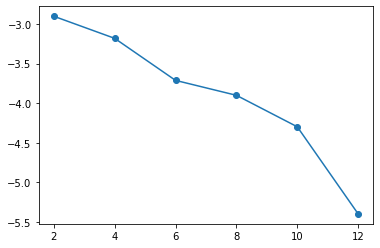

In [ ]:
plt.scatter(num_topics_list, np.mean(coherence_cv, axis=1))
plt.xlabel('Number of Topics')
plt.xlabel('CV Score')

## Run The Model With Highest Topic Coherence

The optimal number of topics seems to be 10. Let us run a model with ten topics.


In [ ]:
ldaseq = DtmModel("/content/drive/My Drive/dtm-linux64", corpus, time_slices, num_topics=10,
                 id2word=dictionary, initialize_lda=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Here we can look at the frequency of certain terms of a particular topic at a certain time slice. Let's look at the frquencies of words of topic 1 at Month 1 and Month 12.

In [ ]:
ldaseq.show_topic(topicid=6, time=0)

[(0.032834894561417485, 'china'),
 (0.017628381430627855, 'tariff'),
 (0.015798200417114543, 'amp'),
 (0.015533972288851425, 'u'),
 (0.014081408386057828, 'country'),
 (0.013721517894761602, 'dollar'),
 (0.01267536235943569, 'billion'),
 (0.012548994597508523, 'year'),
 (0.01236161761248567, 'deal'),
 (0.010506060381870167, 'would'),
 (0.009841357142946872, 'usa'),
 (0.009420385416966241, 'economy'),
 (0.009050028988077448, 'good'),
 (0.00857107223850347, 'much'),
 (0.007406222086839004, 'great'),
 (0.007036541521348904, 'ever'),
 (0.006749697237305389, 'state'),
 (0.006672703387894843, 'product'),
 (0.006424694269721598, 'best'),
 (0.006219600317450486, 'united'),
 (0.006169243933104306, 'company'),
 (0.00601654625952669, 'many'),
 (0.005644158216934746, 'make'),
 (0.005631262208349861, 'history'),
 (0.005533322729861771, 'president'),
 (0.005315532146749341, 'big'),
 (0.0049894142718687265, 'one'),
 (0.004938164381391229, 'trade'),
 (0.004808673984868162, 'far'),
 (0.0047350740202845

In [ ]:
ldaseq.show_topic(topicid=6, time=11)

[(0.02059799013350197, 'china'),
 (0.016240273116643108, 'country'),
 (0.014048418903266168, 'u'),
 (0.013452107221347761, 'amp'),
 (0.012995536331025527, 'year'),
 (0.011260230176035519, 'deal'),
 (0.010410249642366755, 'would'),
 (0.010334140846731893, 'tariff'),
 (0.00998303484480021, 'much'),
 (0.009953720389155034, 'dollar'),
 (0.009900586567647765, 'economy'),
 (0.009029146625320377, 'usa'),
 (0.00844368186145577, 'great'),
 (0.007721175909912852, 'ever'),
 (0.007379352394675775, 'billion'),
 (0.00725822153906203, 'good'),
 (0.006945434701930951, 'best'),
 (0.006809333616684584, 'state'),
 (0.006449561743422628, 'company'),
 (0.006138768799950083, 'history'),
 (0.005911266109694941, 'president'),
 (0.005777879784606159, 'many'),
 (0.0056676478982983745, 'united'),
 (0.005538520948452608, 'big'),
 (0.005454212634769203, 'far'),
 (0.005439546794229482, 'one'),
 (0.005404998332964293, 'trade'),
 (0.005193621281123447, 'better'),
 (0.00495428664326114, 'fed'),
 (0.004929337829001647,

We can look at an even better picture of all the topics by using the pyLDAvis library, which uses PCoA to cluster topics and show the most salient terms in a particular topic. For some reason, this library rearranges the ids of the topics. Something to watch out for.

In [ ]:
pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.7MB/s 
     |████████████████████████████████| 552kB 46.2MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=4636ba9a9d05553e0464ac60682ea4b04a75b64d771d8c7542eb32ded48460a9
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=951acb275df1ac09f058f11d70003427ad994a23f033f9d88cf945497c7bc828
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [ ]:
import pyLDAvis

In [ ]:
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=0, corpus=corpus)
vis_dtm = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_dtm)

In [ ]:
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=52, corpus=corpus)
vis_dtm = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_dtm)

We will define topics by their 20 most salient terms. 

0.  schiff, witch, president, call, russia, said, democrat, never, corrupt, hunt, court, &amp;, adam, even, got, crime, would, case, whistleblower, impeachment
1.  white, house, american, today, conference, p.m., thank, news, wall, you!, press, u, thanks, building, party, turkey, isi, new, honor, great
2.  democrat, &amp;, nothing, impeachment, republican, want, people, dems, left, radical, pelosi, even, bernie, nancy, know, house, get, party, dont, great
3.  fake, news, &amp;, media, china, good, new, would, deal, big, time, much, billion, u.s., far, dollar, news!, story, many, trade
4.  thank, great, you!, mini, mike, big, congratulation, #kag2020, new, going, see, working, keep, american, carolina, night, america, love, hard, @foxandfriends
5.  great, get, federal, governor, new, must, rate, border, book, john, vote, state, john, done, goverment, &amp;, would, fed, interest, reserved
6.  president, trump, look, said, united, joe, its, state, thing, biden, iran, like, would, country, good, sleepy, lot, donald, forward, want
7.  great, total, strong, complete, military, border, love, america, endorsement!, state, great!, protect, support, crime, vote, vet, second, people, happy, #maga
8.  never, &amp;, people, year, rating, market, republican, approval, @foxnews, stock, time, ever, report, crooked, hillary, muller, many, get, best, like
9. great, state, job, united, &amp;, country, best, people, number, many, new, one, usa, history, world, economy, ever, back, military, working

## Evolution of Topics

We will now look at the evolution of the topics talked about by Trump within a year. To do this, we will categorize tweets based on their topic probability distribution (most probable topic is chosen) and then plot the frequency of tweets within a time slice that belong to a particular topic.

In [ ]:
tweet_dates = list(train_data.sort_values('created_at', ascending=True)['created_at'])

In [ ]:
train_data.sort_values('created_at', ascending=True)['created_at'].array

<DatetimeArray>
['2019-05-01 09:56:00', '2019-05-01 10:36:14', '2019-05-01 10:50:34',
 '2019-05-01 11:01:15', '2019-05-01 11:11:42', '2019-05-01 12:06:10',
 '2019-05-01 12:28:53', '2019-05-01 13:03:41', '2019-05-02 02:53:39',
 '2019-05-02 03:09:34',
 ...
 '2020-04-30 11:47:47', '2020-04-30 11:56:44', '2020-04-30 11:59:20',
 '2020-04-30 12:02:43', '2020-04-30 12:11:23', '2020-04-30 12:30:54',
 '2020-04-30 12:31:39', '2020-04-30 12:53:30', '2020-04-30 14:09:10',
 '2020-04-30 18:25:29']
Length: 4983, dtype: datetime64[ns]

In [ ]:
num_topics = 10
tweet_topics = []

for doc_num in range(len(documents)):
  topic_dist = []
  for topic_num in range(0, num_topics):
      topic_dist.append(ldaseq.gamma_[doc_num, topic_num])
  tweet_topics.append(np.argmax(topic_dist))

In [ ]:
topic_counts =  {'topic': tweet_topics, 'date': tweet_dates}

In [ ]:
topic_counts_df = pd.DataFrame(topic_counts, columns=['topic','date'])

In [ ]:
topic_counts_df.head()

,topic,date
0,3,2019-05-01 09:56:00
61,0,2019-05-01 10:36:14
62,9,2019-05-01 10:50:34
63,1,2019-05-01 11:01:15
64,6,2019-05-01 11:11:42


In [ ]:
time_freqs_df = pd.crosstab(topic_counts_df['date'].dt.to_period("M"), topic_counts_df.topic, normalize='index')

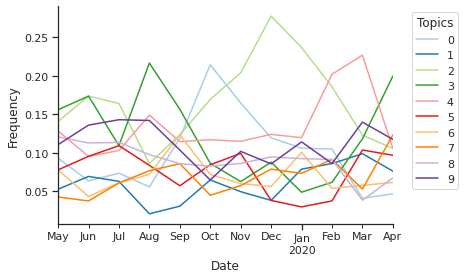

In [ ]:
# Hope to convert this into a streamgraph
sns.set_palette(sns.color_palette('Paired', 12))
time_freqs_df.plot()
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left",  title="Topics")
plt.xlabel('Date')
plt.ylabel('Frequency')
sns.despine()

Some highlights:

August 2019: Trump continually attacks the media and democrats for unfair treatment as he faced numerous controversies, including mass shootings, recession fears, a trade war, and his former director of communication Omorosa Manigault publising her memoir *Unhinged*. We can see that tweets relating to topic 3, which represents his attacks on the media, spike around this time. You can also observe that his tweets relating to white house press conferences (topic 1) drop during this month.

October 2019: The impeachment inquiry begins, initiated to invetstigate claims by a whistleblower that alleged that Trump asked Ukrainian offficials to investigate Joe and Hunter Biden. Here we can see that tweets pertaining to the impeachment inquiry increase in frequency (Topic 0).

December 2019: Trump is impeached and he will soon have his day in court. Thrpughout the month and especially during Christmas time, he attacks democrats for their part in the impeachment inquiries. Tweets pertaining to attacks on the democratic party spike (Topic 2).

March 2020: The 2020 election continues, with Super Tuesday being the turning point of the election season. The coronavirus pandemic also starts to take a turn for the worst, as many states place stay-at-home orders to curb the spread of the virus. We see tweets pertaining to the election spike (Topic 4), and start to see an increase of tweets relating to attacks on the media (topic 3)/

